In [1]:
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    MaxAbsScaler,
)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sqlite3 as sq3

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

In [2]:
data = pd.read_csv("Indian Liver Patient Dataset (ILPD).csv")

data.dtypes.value_counts()

float64    5
int64      5
object     1
dtype: int64

In [3]:
data.head()

,Age,Gender,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A/G Ratio,Selector
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1


In [4]:
print("##" * 30)
print(" " * 17, "Data set Information")
print("##" * 30)
data.info()

############################################################
                  Data set Information
############################################################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Age        583 non-null    int64  
 1   Gender     583 non-null    object 
 2   TB         583 non-null    float64
 3   DB         583 non-null    float64
 4   Alkphos    583 non-null    int64  
 5   Sgpt       583 non-null    int64  
 6   Sgot       583 non-null    int64  
 7   TP         583 non-null    float64
 8   ALB        583 non-null    float64
 9   A/G Ratio  579 non-null    float64
 10  Selector   583 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 50.2+ KB


The following observations are made from using the `info()` function on the dataframe:

* It is clear that the data has $583$ elements or rows and $11$ columns. 
* The column A/G Ratio has some missing elements.
* All columns except the Selector column are of numeric type (i.e.either int ot float)
* 

Next, we separate the categorical and numerical variables to allow us to encode their values:

In [5]:
# select all column names
all_columns = data.columns.to_list()
print("##" * 30)
print(" " * 17, "All Columns in Data")
print("##" * 30)
print(all_columns)

############################################################
                  All Columns in Data
############################################################
['Age', 'Gender', 'TB', 'DB', 'Alkphos', 'Sgpt', 'Sgot', 'TP', 'ALB', 'A/G Ratio', 'Selector']


In [6]:
numeric_variables = data.select_dtypes(include=[int, float]).columns.to_list()
print("##" * 30)
print(" " * 17, "Numeric Columns in Data")
print("##" * 30)
print(numeric_variables)

############################################################
                  Numeric Columns in Data
############################################################
['Age', 'TB', 'DB', 'Alkphos', 'Sgpt', 'Sgot', 'TP', 'ALB', 'A/G Ratio', 'Selector']


In [7]:
categorical_variables = list(set(all_columns) - set(numeric_variables))
print("##" * 30)
print(" " * 17, "Categorical Columns in Data")
print("##" * 30)
print(categorical_variables)

############################################################
                  Categorical Columns in Data
############################################################
['Gender']


Below, we use the `describe()` function on the numeric variable columns to the get a brief statistics on the data. It is clear that the data is not scaled as the `min` and `max` values are far apart. This requires that in the preprocessing of the data for the model training, we can do some feature scaling to speed up the learning rate during the training. 

`value_counts` is applied to categorical variables columns to obtain the unique elements in their columns. Here we have two classes: Male and Female which appears 

In [8]:
data[numeric_variables].describe()

,Age,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A/G Ratio,Selector
count,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,579.000000,583.000000
mean,44.746141,3.298799,1.486106,290.576329,80.713551,109.910806,6.483190,3.141852,0.947064,1.286449
std,16.189833,6.209522,2.808498,242.937989,182.620356,288.918529,1.085451,0.795519,0.319592,0.452490
min,4.000000,0.400000,0.100000,63.000000,10.000000,10.000000,2.700000,0.900000,0.300000,1.000000
25%,33.000000,0.800000,0.200000,175.500000,23.000000,25.000000,5.800000,2.600000,0.700000,1.000000
50%,45.000000,1.000000,0.300000,208.000000,35.000000,42.000000,6.600000,3.100000,0.930000,1.000000
75%,58.000000,2.600000,1.300000,298.000000,60.500000,87.000000,7.200000,3.800000,1.100000,2.000000
max,90.000000,75.000000,19.700000,2110.000000,2000.000000,4929.000000,9.600000,5.500000,2.800000,2.000000


In [9]:
data[categorical_variables].value_counts()

Gender
Male      441
Female    142
dtype: int64

The target column, `Selector` is numeric and has only two unique values (using `unique()` gives the unique values and `nunique()` gives the number of unique values): $1$ and $2$ and the target has an unbalanced class and this should inform the choice of performance metrics used in evaluating the training models. See below:

In [10]:
target = "Selector"
print("Unique entries for the target: \n", data[target].unique())
print(" ")
print("Proportion of the target entries: \n",
      data[target].value_counts(normalize=True))

Unique entries for the target: 
 [1 2]
 
Proportion of the target entries: 
 1    0.713551
2    0.286449
Name: Selector, dtype: float64


In [11]:
df_uniques = data.nunique()
print("##" * 30)
print(" " * 17, "Number of unique entries for all coulmns:")
print("##" * 30)
print(df_uniques)

############################################################
                  Number of unique entries for all coulmns:
############################################################
Age           72
Gender         2
TB           113
DB            80
Alkphos      263
Sgpt         152
Sgot         177
TP            58
ALB           40
A/G Ratio     69
Selector       2
dtype: int64


To perform `one-hot-encoding` on the nominal categorical variables, the data type needs to prefarabley be a string and so the need to map the int to string types as done  just below.

In [12]:
mapping_selector = {1: "liver disease", 2: "no liver disease"}

data["Selector"] = data["Selector"].map(mapping_selector)
# data['Selector'] = data.Selector.replace(1,"liver disease").replace(2,"no liver disease").astype(np.int)


print(data["Selector"].unique())

['liver disease' 'no liver disease']


In [13]:
data.head(10)

,Age,Gender,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A/G Ratio,Selector
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,liver disease
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,liver disease
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,liver disease
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,liver disease
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,liver disease
5,46,Male,1.8,0.7,208,19,14,7.6,4.4,1.30,liver disease
6,26,Female,0.9,0.2,154,16,12,7.0,3.5,1.00,liver disease
7,29,Female,0.9,0.3,202,14,11,6.7,3.6,1.10,liver disease
8,17,Male,0.9,0.3,202,22,19,7.4,4.1,1.20,no liver disease
9,55,Male,0.7,0.2,290,53,58,6.8,3.4,1.00,liver disease


## Duplicates
To remove any instability of our model due to over-represenation, we needd to remove duplicates (13 in this case) in our data using `drop_duplicates(inplace=True)`

In [14]:
print("##" * 30)
print(" " * 17, "Number of dupicated entries:")
print("##" * 30)
print(data.duplicated().sum())

############################################################
                  Number of dupicated entries:
############################################################
13


In [15]:
# duplicates removed from the original dataset
data.drop_duplicates(inplace=True)

In [16]:
print("##" * 30)
print(" " * 17, "Number of dupicated entries:")
print("##" * 30)
print(data.duplicated().sum())

############################################################
                  Number of dupicated entries:
############################################################
0


## Missing Data
Handle missing data in this case by removing the rows with the missing data (not the column) by using `dropna(axis=0)`. I have written a function to perform this this task:


```python
def handle_missing_data(data, strategy="mean", columns=None):
    """Handle missing data by filling or dropping.
    values = {'col1': 0, 'col2': 1, 'col3': 2 }
    df.fillna(value=values)
    """
    # to do: add some condition to determine the data type of the column
    if strategy == "mean":
        my_imputer = SimpleImputer(strategy="mean")
        data = my_imputer.fit_transform(data)

    elif strategy == "median":
        my_imputer = SimpleImputer(strategy="median")
        data = my_imputer.fit_transform(data)

    elif strategy == "drop":
        if columns:
            # drop columns with missing values
            data.dropna(axis=1, inplace=True)
        else:
            # drop rows with missing values
            data.dropna(axis=0, inplace=True)
    else:
        raise ValueError("Invalid strategy. Use 'mean', 'median', or 'drop'")
    return data
```


In [17]:
print("##" * 30)
print(" " * 17, "Number of missing entries:")
print("##" * 30)
print(data.isnull().sum())

############################################################
                  Number of missing entries:
############################################################
Age          0
Gender       0
TB           0
DB           0
Alkphos      0
Sgpt         0
Sgot         0
TP           0
ALB          0
A/G Ratio    4
Selector     0
dtype: int64


In [18]:
data.dropna(axis=0, inplace=True)
print("##" * 30)
print(" " * 17, "Number of missing entries:")
print("##" * 30)
print(data.isnull().sum())

############################################################
                  Number of missing entries:
############################################################
Age          0
Gender       0
TB           0
DB           0
Alkphos      0
Sgpt         0
Sgot         0
TP           0
ALB          0
A/G Ratio    0
Selector     0
dtype: int64


## One-hot-encoding

In [19]:
# drop_fist= True to prevent multicollinearity
data_encoded = pd.get_dummies(data, columns=["Gender", "Selector"], drop_first=True)

data_encoded.head(10)

,Age,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A/G Ratio,Gender_Male,Selector_no liver disease
0,65,0.7,0.1,187,16,18,6.8,3.3,0.90,0,0
1,62,10.9,5.5,699,64,100,7.5,3.2,0.74,1,0
2,62,7.3,4.1,490,60,68,7.0,3.3,0.89,1,0
3,58,1.0,0.4,182,14,20,6.8,3.4,1.00,1,0
4,72,3.9,2.0,195,27,59,7.3,2.4,0.40,1,0
5,46,1.8,0.7,208,19,14,7.6,4.4,1.30,1,0
6,26,0.9,0.2,154,16,12,7.0,3.5,1.00,0,0
7,29,0.9,0.3,202,14,11,6.7,3.6,1.10,0,0
8,17,0.9,0.3,202,22,19,7.4,4.1,1.20,1,1
9,55,0.7,0.2,290,53,58,6.8,3.4,1.00,1,0


In [20]:
data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 566 entries, 0 to 582
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        566 non-null    int64  
 1   TB                         566 non-null    float64
 2   DB                         566 non-null    float64
 3   Alkphos                    566 non-null    int64  
 4   Sgpt                       566 non-null    int64  
 5   Sgot                       566 non-null    int64  
 6   TP                         566 non-null    float64
 7   ALB                        566 non-null    float64
 8   A/G Ratio                  566 non-null    float64
 9   Gender_Male                566 non-null    uint8  
 10  Selector_no liver disease  566 non-null    uint8  
dtypes: float64(5), int64(4), uint8(2)
memory usage: 45.3 KB


In [21]:
data_encoded.describe()

,Age,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A/G Ratio,Gender_Male,Selector_no liver disease
count,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000
mean,44.886926,3.338869,1.505830,292.567138,80.143110,109.892226,6.494876,3.145583,0.948004,0.756184,0.286219
std,16.274893,6.286728,2.841485,245.936559,182.044881,291.841897,1.087512,0.795745,0.319635,0.429763,0.452393
min,4.000000,0.400000,0.100000,63.000000,10.000000,10.000000,2.700000,0.900000,0.300000,0.000000,0.000000
25%,33.000000,0.800000,0.200000,176.000000,23.000000,25.000000,5.800000,2.600000,0.700000,1.000000,0.000000
50%,45.000000,1.000000,0.300000,208.000000,35.000000,41.000000,6.600000,3.100000,0.950000,1.000000,0.000000
75%,58.000000,2.600000,1.300000,298.000000,60.750000,87.000000,7.200000,3.800000,1.100000,1.000000,1.000000
max,90.000000,75.000000,19.700000,2110.000000,2000.000000,4929.000000,9.600000,5.500000,2.800000,1.000000,1.000000


## Split data into predictor and target variables

In [22]:
target = "Selector_no liver disease"
X = data_encoded.drop(target, axis=1)
y = data_encoded[target]

# Correlation and Multicollinearity

A larger correlation between the a feature an a target means the the feature has a greater influence on the prediction. When independent variables have a high correlations, this causes that the model results are unstable, since the models overfit and making it difficlt to choose the most signficant features or variables. This called `multicollinearity`. Using `sns.pairplot` we can immediately visualize the relationship between all feature variables. Looking at our pairplot, we see somekind of separation between the people with and without liver disease. Which means, there is a chance we can build a classifier to separate the two classes. We see a large correlation between DB and TB, Sgot and Sgpt, TP and ALB  and A/G ratio and ALB. At this point we will not do feature elimination but we will rely on regularization to reduce their effects on prediction.



In [23]:
# correlation between the freatures and the target. None of the features correlates with the target
correlations = X.corrwith(y)
correlations.sort_values(inplace=True)
correlations

DB            -0.250926
TB            -0.224467
Alkphos       -0.186057
Sgpt          -0.161617
Sgot          -0.151009
Age           -0.133821
Gender_Male   -0.077396
TP             0.036443
ALB            0.165273
A/G Ratio      0.171402
dtype: float64

[(-0.3, 0.3), Text(0, 0.5, 'correlation with target')]

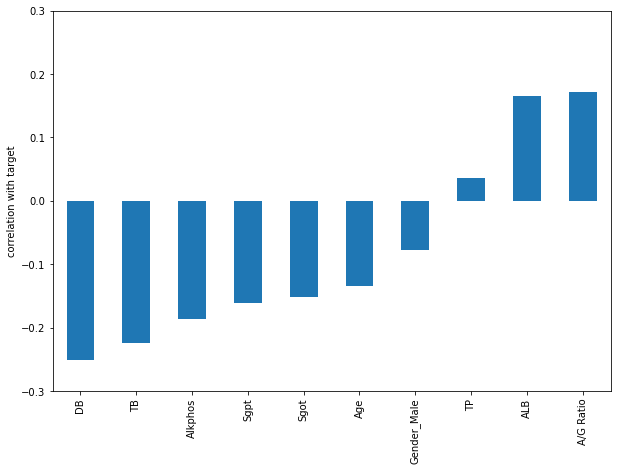

In [24]:
# this gives a better way to visualize the correlation between each feature and target
ax = correlations.plot(kind="bar", figsize=(10, 7))
ax.set(ylim=[-0.3, 0.3], ylabel="correlation with target")

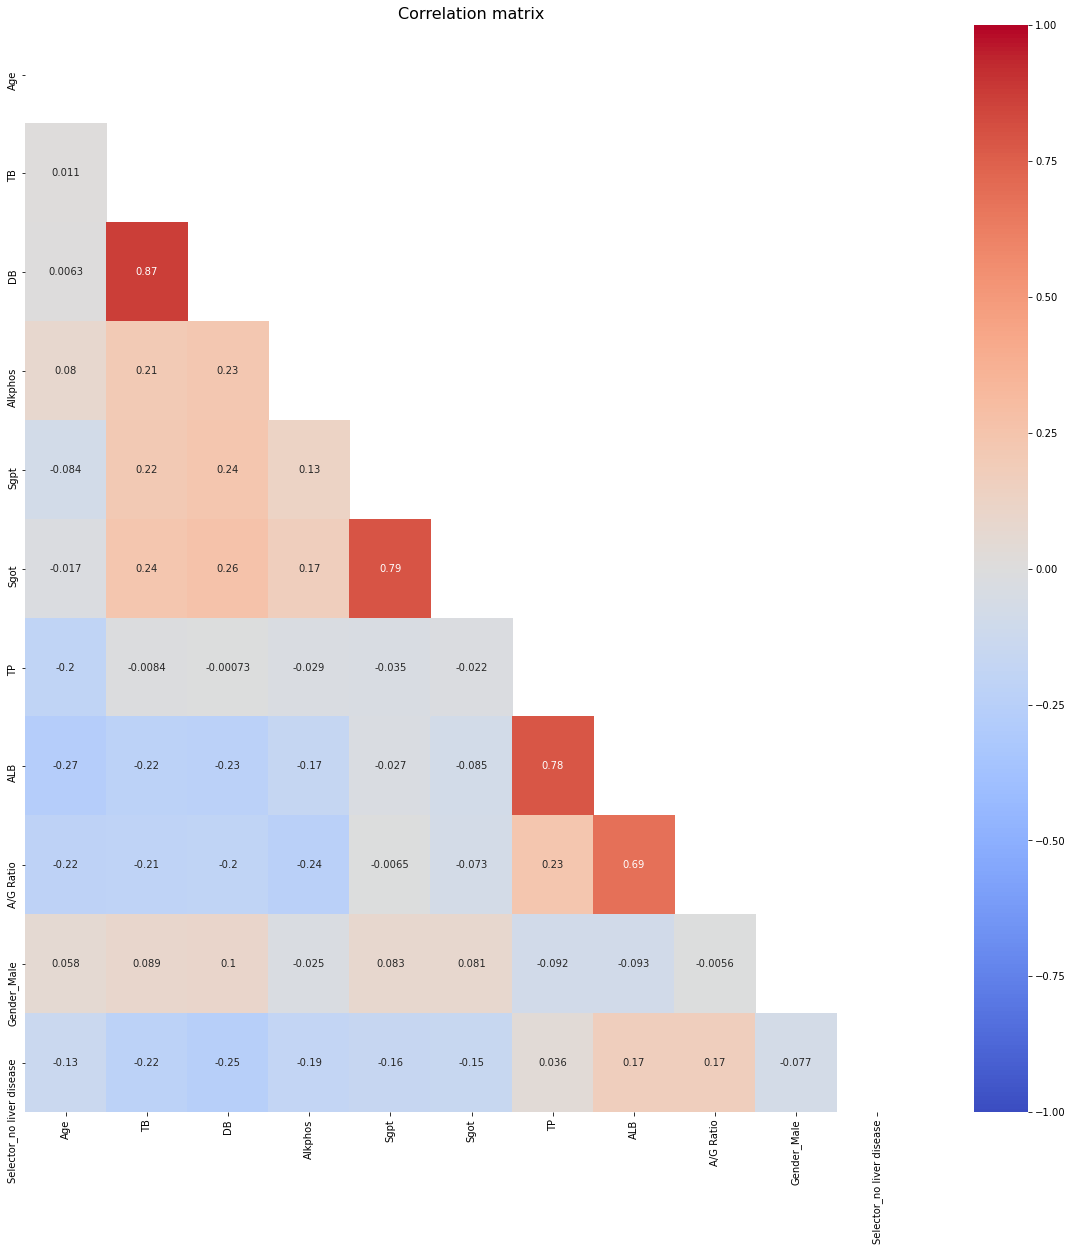

In [25]:
# correlation matrix for all the data is plotted below
corr = data_encoded.corr()
plt.figure(figsize=(20, 20))
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1, mask=mask)
plt.title("Correlation matrix", fontsize=16)
plt.show()

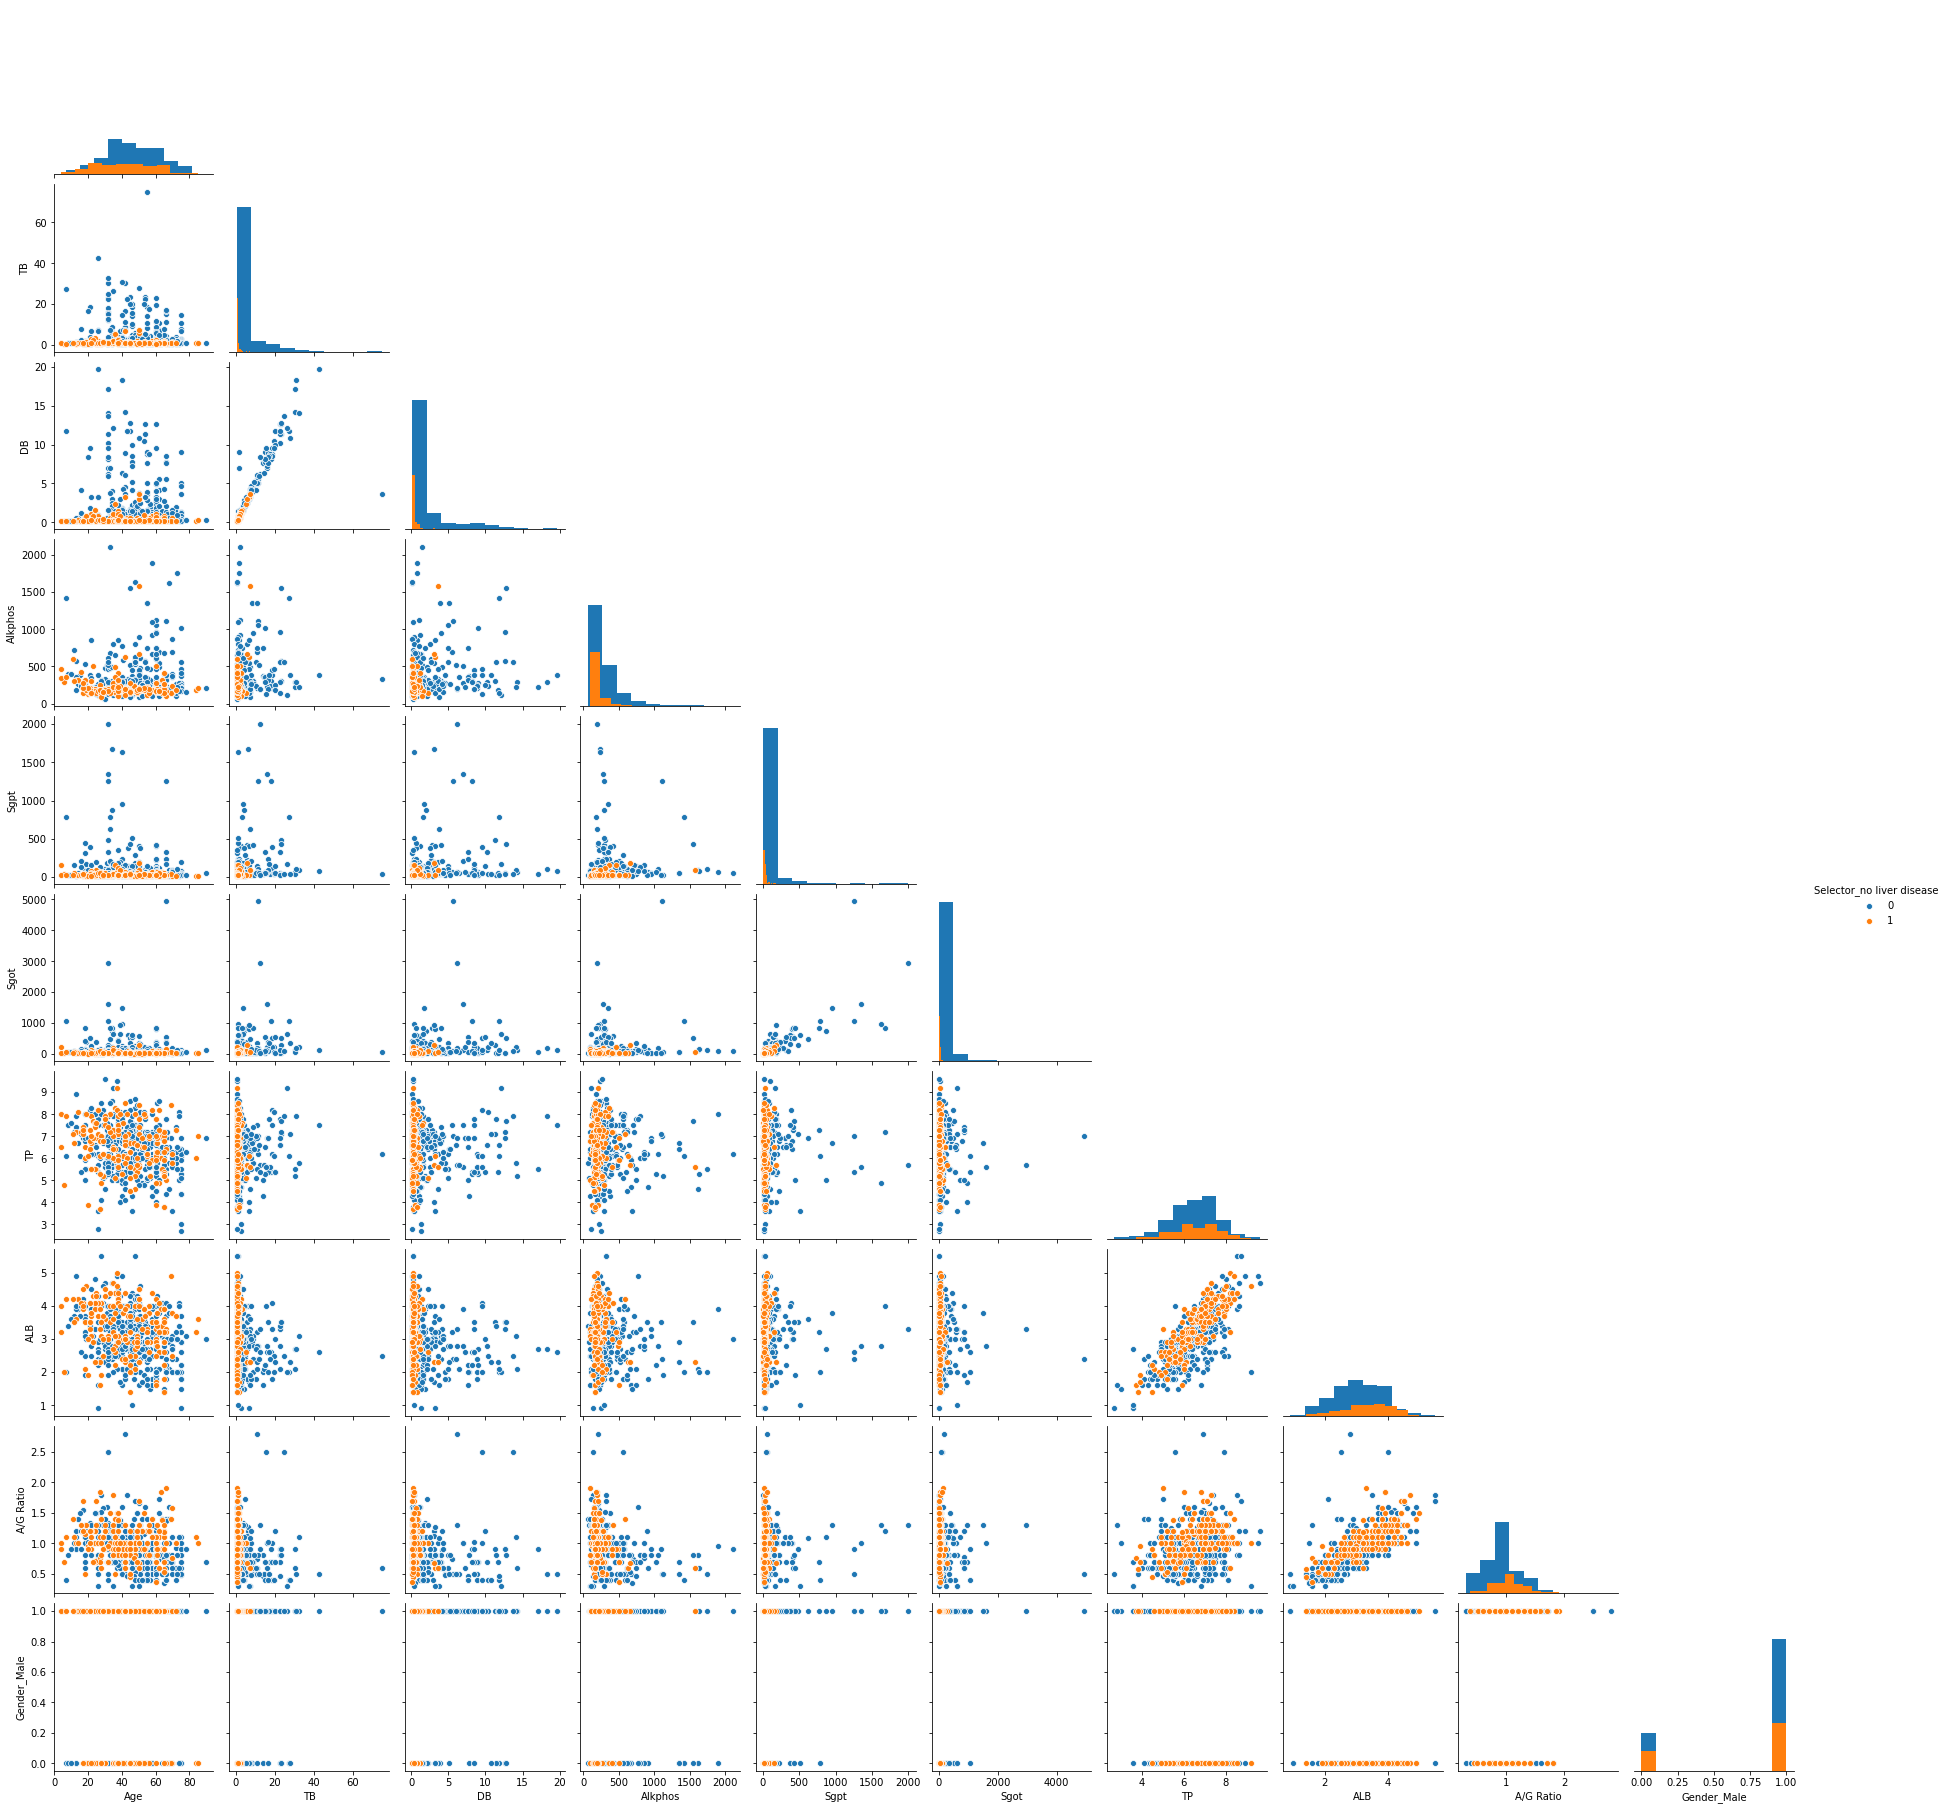

In [26]:
sns.pairplot(
    data_encoded,
    hue="Selector_no liver disease",
    diag_kind="hist",
    corner=True,
    kind="scatter",
)

# Feature Scaling

Here, the data is split into traing and test sets for the sole purpose of evaluating the model. Each of these features are scaled so that all the features are on the same scale. For this work, `MinMaxScaler` from `sklearn.preprocessing` is used.

In [27]:
# Get the split indexes
# This creates a generator to ensure equal proportions in both train and test sets and generally ussed for a skewed data
# strat_shuf_split = StratifiedShuffleSplit(
#     n_splits=1, test_size=0.3, random_state=42)

# Get the index values from the generator
# train_idx, test_idx = next(strat_shuf_split.split(X, y))

# print(train_idx)
# Create the data sets
# X_train = X.iloc[train_idx, :]
# y_train = y.iloc[train_idx]

# X_test = X.iloc[test_idx, :]
# y_test = y.iloc[test_idx]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print("X_train shape: ", X_train.shape)
print(" ")

print("y_train shape: ", y_train.shape)
print(" ")

print("X_test shape: ", X_test.shape)
print(" ")

print("y_test shape: ", y_test.shape)
print(" ")

print("proportions of y_train: \n", y_train.value_counts(normalize=True))
print(" ")

print("proportions of y_test: \n", y_test.value_counts(normalize=True))

X_train shape:  (396, 10)
 
y_train shape:  (396,)
 
X_test shape:  (170, 10)
 
y_test shape:  (170,)
 
proportions of y_train: 
 0    0.732323
1    0.267677
Name: Selector_no liver disease, dtype: float64
 
proportions of y_test: 
 0    0.670588
1    0.329412
Name: Selector_no liver disease, dtype: float64


In [28]:
scaler = StandardScaler()  # MinMaxScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

## Model Training and Choice of Model
Here, different classification models are used and for each model. Hyperparameter fine tunning is done to select the best parameters for each model (using `GridSearcgCV` from sklear). The different models are then compared to choose the best model. The choice of the different models is releveant for the goal of the project: either prediction or interpretation (considered both intrinsic like decision trees, etc and post-hoc like svm, ensemble tress, etc models). It is also relevant as the different models have their pros and cons in terms of how fast it trains or fits, memory intensiveness (usage line KNN models that requires a lot of memory and slow at predictions but fast at training).

Th models considered are Logistic regression, K-nearest nighbor, support vector machine, decision tree, bagging, rando forest, extra random trees, AdaBoost, and Gradient Boosting. The choice of the best model, in this work, is the model with the highest f1-score which is the decision tree classifier. f1_score balances the recall and precision so we are not mislead by the accuracy metric since the data set in unbalance.

The next task is to improve the perfoarmance of the best model and explore the feature importance.

In [29]:
logreg = LogisticRegression(solver="liblinear")
parameters = [
    {
        "penalty": ["l1", "l2"],
        "C": [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 100],
        "max_iter": [100, 150, 1000, 2500, 5000],
    },
]

cv = RepeatedStratifiedKFold(n_splits=15, n_repeats=5, random_state=1)

grid_search_logreg = GridSearchCV(
    estimator=logreg,
    param_grid=parameters,
    scoring="accuracy",
    cv=25,
    verbose=0,
    error_score="raise",
)

logreg = grid_search_logreg.fit(X_train_s, y_train)

# Make predictions on the test data
y_pred = grid_search_logreg.predict(X_test_s)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

print(
    "Best score (accuracy): \n",
    grid_search_logreg.best_score_,
    "\n \n",
    "Best hyperparameters: \n",
    grid_search_logreg.best_params_,
    "\n \n",
    "Best coefficients: \n",
    grid_search_logreg.best_estimator_.coef_,
    "\n",
)

Accuracy: 0.6882352941176471
Precision: 0.56
Recall: 0.25
F1-Score: 0.34567901234567905
Best score (accuracy): 
 0.7325 
 
 Best hyperparameters: 
 {'C': 5, 'max_iter': 100, 'penalty': 'l1'} 
 
 Best coefficients: 
 [[-0.18170707 -1.01219174 -0.89357163 -0.61046584 -2.38273728  0.
  -0.78662259  1.13118394 -0.45219075 -0.04867658]] 



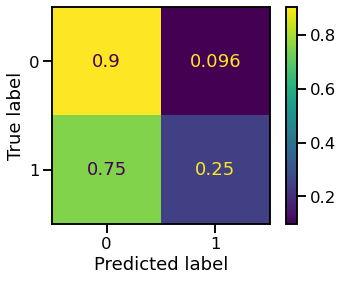

In [31]:
sns.set_context("talk")
cm = confusion_matrix(y_test, y_pred, normalize="true")
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=grid_search_logreg.classes_
)
disp.plot()
plt.show()

In [32]:
# KNN

cv = RepeatedStratifiedKFold(n_splits=15, n_repeats=5, random_state=1)

estimator_KNN = KNeighborsClassifier(algorithm="auto")
parameters_KNN = {
    "n_neighbors": (1, 10, 1),
    "leaf_size": (20, 40, 1),
    "p": (1, 2),
    "weights": ("uniform", "distance"),
    "metric": ("minkowski", "chebyshev"),
}

# with GridSearch
grid_search_KNN = GridSearchCV(
    estimator=estimator_KNN,
    param_grid=parameters_KNN,
    n_jobs=-1,
    cv=25,
)

knn = grid_search_KNN.fit(X_train_s, y_train)

# Make predictions on the test data
y_pred = grid_search_KNN.predict(X_test_s)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

print(
    "Best score (accuracy): \n",
    grid_search_KNN.best_score_,
    "\n \n",
    "Best hyperparameters: \n",
    grid_search_KNN.best_params_,
    "\n \n",
    "Best coefficients: \n",
    grid_search_KNN.best_estimator_,
    "\n",
)

Accuracy: 0.6588235294117647
Precision: 0.42857142857142855
Recall: 0.10714285714285714
F1-Score: 0.17142857142857143
Best score (accuracy): 
 0.7071666666666667 
 
 Best hyperparameters: 
 {'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 10, 'p': 1, 'weights': 'uniform'} 
 
 Best coefficients: 
 KNeighborsClassifier(leaf_size=20, n_neighbors=10, p=1) 



In [33]:
# SVM

model = SVC()


grid = [
    {
        "C": [0.1, 1, 10, 100],
        "gamma": [10, 2, 1, 0.1, 0.01],
        "kernel": ["rbf", "poly", "sigmoid"],
    }
]

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

grid_search_SVC = GridSearchCV(
    estimator=model,
    param_grid=grid,
    n_jobs=-1,
    cv=15,
    error_score=0,
)

svc = grid_search_SVC.fit(X_train_s, y_train)

print(
    "Best score (precision): \n",
    grid_search_SVC.best_score_,
    "\n \n",
    "Best hyperparameters: \n",
    grid_search_SVC.best_params_,
    "\n \n",
    "Best coefficients: \n",
    grid_search_SVC.best_estimator_,
    "\n",
)

Best score (precision): 
 0.7373219373219371 
 
 Best hyperparameters: 
 {'C': 1, 'gamma': 10, 'kernel': 'rbf'} 
 
 Best coefficients: 
 SVC(C=1, gamma=10) 



In [49]:
# Make predictions on the test data
y_pred = grid_search_SVC.predict(X_test_s)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Accuracy: 0.6705882352941176
Precision: 0.0
Recall: 0.0
F1-Score: 0.0


/home/godwin/Desktop/Organised/python/python/ML_Foundation/.venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
# DecisionTreee

param_grid = {
    "max_depth": range(1, 100, 2),
    "max_features": range(1, X_train_s.shape[1] + 1),
}

grid_search_DT = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    scoring="accuracy",
    n_jobs=-1,
    cv=25,
)

grid_search_DT = grid_search_DT.fit(X_train, y_train)

# Make predictions on the test data
y_pred = grid_search_DT.predict(X_test_s)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)


print(
    "Best score (precision): \n",
    grid_search_DT.best_score_,
    "\n \n",
    "Best hyperparameters: \n",
    grid_search_DT.best_params_,
    "\n \n",
    "Best coefficients: \n",
    grid_search_DT.best_estimator_,
    "\n",
)

Accuracy: 0.40588235294117647
Precision: 0.35668789808917195
Recall: 1.0
F1-Score: 0.5258215962441315
Best score (precision): 
 0.7576666666666667 
 
 Best hyperparameters: 
 {'max_depth': 7, 'max_features': 3} 
 
 Best coefficients: 
 DecisionTreeClassifier(max_depth=7, max_features=3, random_state=42) 



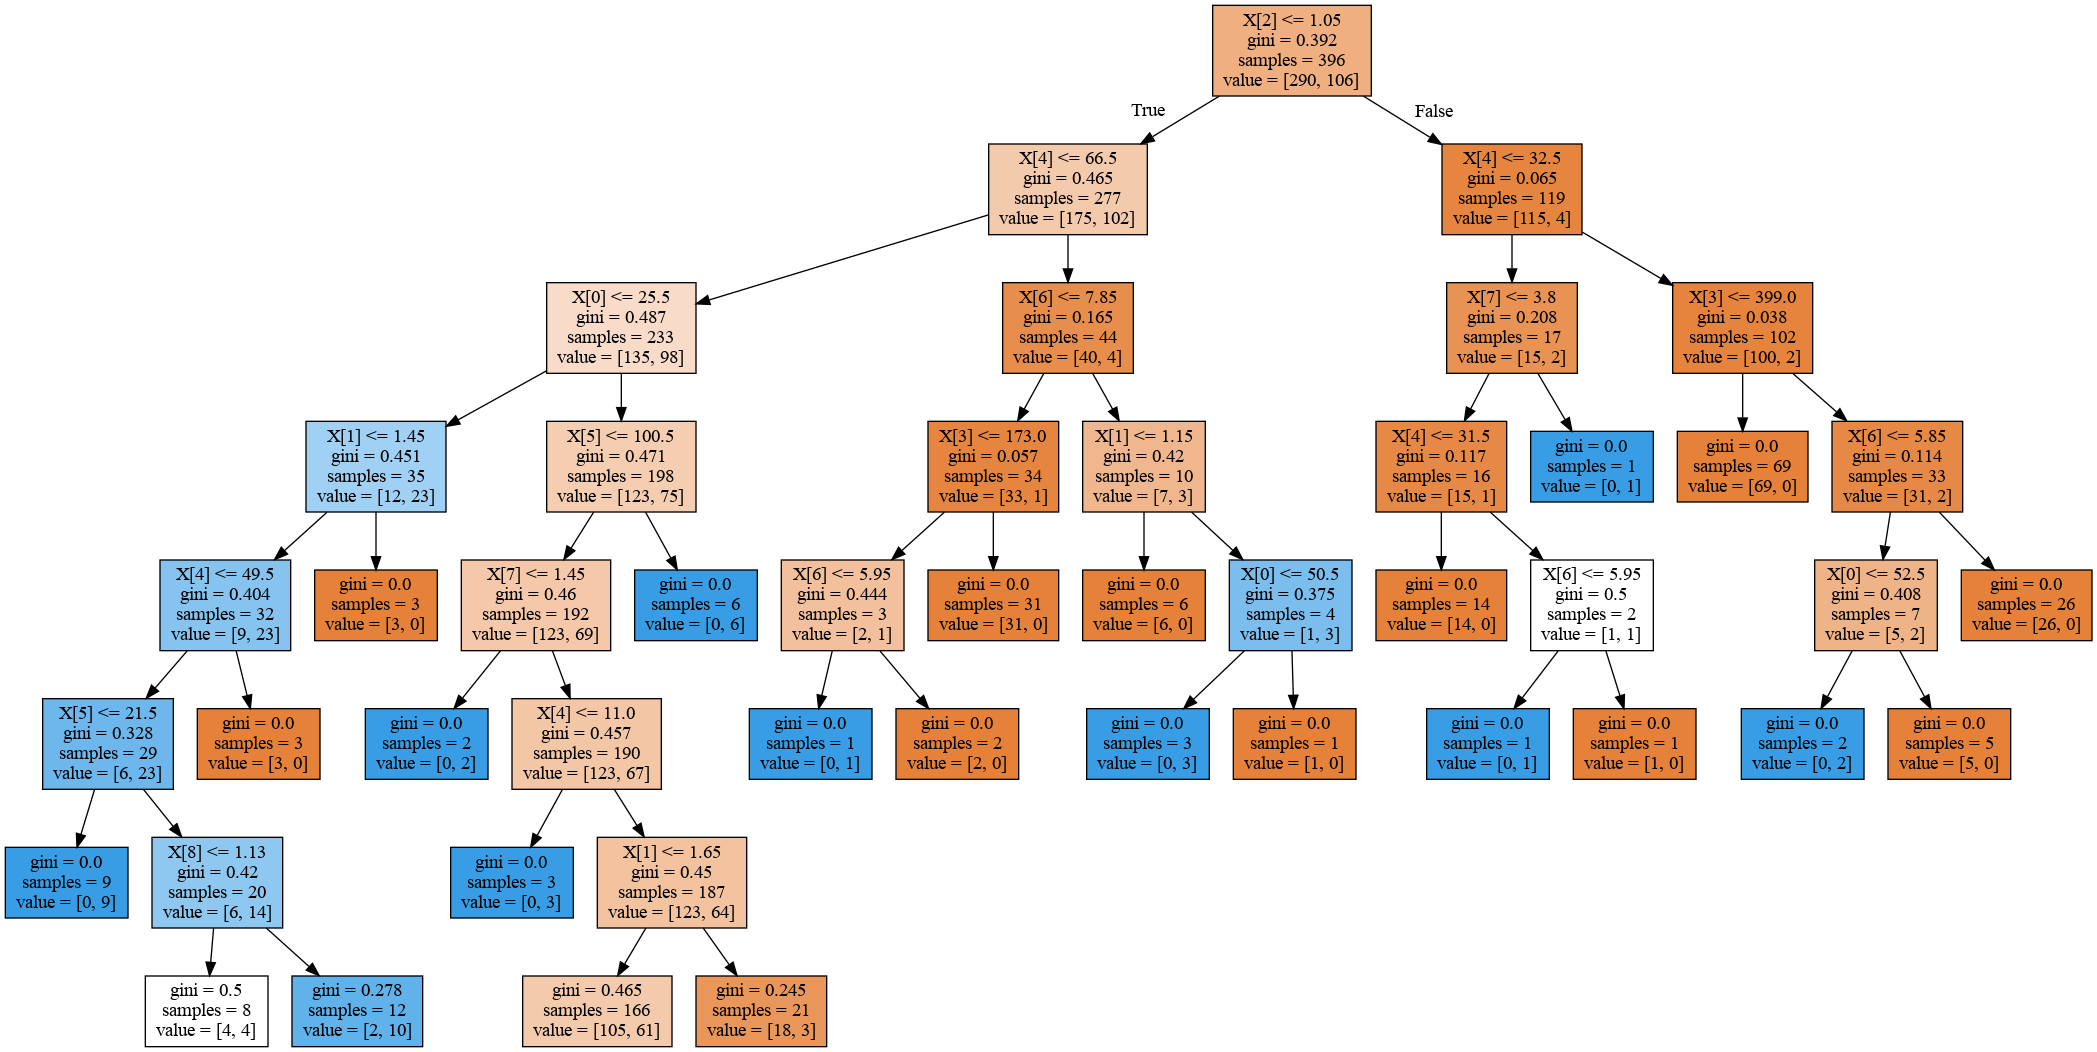

In [35]:
# Visualizing the decision tree

from io import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()

export_graphviz(grid_search_DT.best_estimator_, out_file=dot_data, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

# View the tree image
filename = "liver_tree.png"
graph.write_png(filename)
Image(filename=filename)

In [ ]:
def measure_error(y_true, y_pred, label):
    return pd.Series(
        {
            "accuracy": accuracy_score(y_true, y_pred),
            "precision": precision_score(y_true, y_pred),
            "recall": recall_score(y_true, y_pred),
            "f1": f1_score(y_true, y_pred),
        },
        name=label,
    )


y_train_pred_gr = grid_search_DT.predict(X_train)
y_test_pred_gr = grid_search_DT.predict(X_test)

train_test_gr_error = pd.concat(
    [
        measure_error(y_train, y_train_pred_gr, "train"),
        measure_error(y_test, y_test_pred_gr, "test"),
    ],
    axis=1,
)

train_test_gr_error

/home/godwin/Desktop/Organised/python/python/ML_Foundation/.venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,train,test
accuracy,0.714646,0.711765
precision,0.000000,0.000000
recall,0.000000,0.000000
f1,0.000000,0.000000


In [41]:
# Ensemble - Bagging or bootstrap aggregating

param_grid = {
    "base_estimator__max_depth": range(1, 101, 10),
    "n_estimators": range(1, 101, 10),
}

grid_search_Bag = GridSearchCV(
    BaggingClassifier(
        base_estimator=DecisionTreeClassifier(
            random_state=42,
        )
    ),
    param_grid=param_grid,
    scoring="accuracy",
    n_jobs=-1,
    cv=25,
)

Bag = grid_search_Bag.fit(X_train_s, y_train)


# Make predictions on the test data
y_pred = grid_search_Bag.predict(X_test_s)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)



Accuracy: 0.6470588235294118
Precision: 0.42857142857142855
Recall: 0.21428571428571427
F1-Score: 0.2857142857142857


In [42]:
print(
    "Best score (precision): \n",
    grid_search_Bag.best_score_,
    "\n \n",
    "Best hyperparameters: \n",
    grid_search_Bag.best_params_,
    "\n \n",
    "Best coefficients: \n",
    grid_search_Bag.best_estimator_,
    "\n",
)

Best score (precision): 
 0.7473333333333333 
 
 Best hyperparameters: 
 {'base_estimator__max_depth': 21, 'n_estimators': 31} 
 
 Best coefficients: 
 BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=21,
                                                        random_state=42),
                  n_estimators=31) 



In [43]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

param_grid = {
    "n_estimators": range(1, 101, 10),
    "max_depth": range(1, 101, 10),
    "max_features": ["auto", "sqrt", "log2"],
}

search = GridSearchCV(
    estimator=model, param_grid=param_grid, scoring="accuracy")
search.fit(X_train, y_train)

# Make predictions on the test data
y_pred = search.predict(X_test_s)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)


print(
    "Best score (precision): \n",
    grid_search_DT.best_score_,
    "\n \n",
    "Best hyperparameters: \n",
    grid_search_DT.best_params_,
    "\n \n",
    "Best coefficients: \n",
    grid_search_DT.best_estimator_,
    "\n",
)

Accuracy: 0.40588235294117647
Precision: 0.3404255319148936
Recall: 0.8571428571428571
F1-Score: 0.4873096446700508
Best score (precision): 
 0.7576666666666667 
 
 Best hyperparameters: 
 {'max_depth': 7, 'max_features': 3} 
 
 Best coefficients: 
 DecisionTreeClassifier(max_depth=7, max_features=3, random_state=42) 



In [45]:
from sklearn.ensemble import ExtraTreesClassifier


model = ExtraTreesClassifier(
    oob_score=True, random_state=42, warm_start=True, bootstrap=True, n_jobs=-1
)

param_grid = {
    "n_estimators": range(1, 101, 10),
    "max_depth": range(1, 101, 10),
    "max_features": ["auto", "sqrt", "log2"],
}

search_ET = GridSearchCV(estimator=model, param_grid=param_grid, scoring="accuracy")
search_ET.fit(X_train, y_train)

# Make predictions on the test data
y_pred = search_ET.predict(X_test_s)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)


print(
    "Best score (precision): \n",
    search_ET.best_score_,
    "\n \n",
    "Best hyperparameters: \n",
    search_ET.best_params_,
    "\n \n",
    "Best coefficients: \n",
    search_ET.best_estimator_,
    "\n",
)

/home/godwin/Desktop/Organised/python/python/ML_Foundation/.venv/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/godwin/Desktop/Organised/python/python/ML_Foundation/.venv/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/godwin/Desktop/Organised/python/python/ML_Foundation/.venv/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/godwin/Desktop/Organised/python/python/ML_Foundation/.venv/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:545: RuntimeWarning: invalid value encounte

Accuracy: 0.3941176470588235
Precision: 0.30578512396694213
Recall: 0.6607142857142857
F1-Score: 0.4180790960451977
Best score (precision): 
 0.745126582278481 
 
 Best hyperparameters: 
 {'max_depth': 21, 'max_features': 'auto', 'n_estimators': 21} 
 
 Best coefficients: 
 ExtraTreesClassifier(bootstrap=True, max_depth=21, n_estimators=21, n_jobs=-1,
                     oob_score=True, random_state=42, warm_start=True) 



In [46]:
from sklearn.ensemble import GradientBoostingClassifier

# The parameters to be fit
tree_list = [15, 25, 50, 100, 200, 400]

param_grid = {
    "n_estimators": tree_list,
    "learning_rate": [0.1, 0.01, 0.001, 0.0001],
    "subsample": [1.0, 0.5],
    "max_features": [1, 2, 3, 4],
}

# The grid search object
GV_GBC = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid=param_grid,
    scoring="accuracy",
    n_jobs=-1,
)

# Do the grid search
GV_GBC = GV_GBC.fit(X_train_s, y_train)

y_pred = GV_GBC.predict(X_test_s)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)


print(
    "Best score (precision): \n",
    GV_GBC.best_score_,
    "\n \n",
    "Best hyperparameters: \n",
    GV_GBC.best_params_,
    "\n \n",
    "Best coefficients: \n",
    GV_GBC.best_estimator_,
    "\n",
)

Accuracy: 0.6764705882352942
Precision: 0.5384615384615384
Recall: 0.125
F1-Score: 0.20289855072463767
Best score (precision): 
 0.7525632911392405 
 
 Best hyperparameters: 
 {'learning_rate': 0.1, 'max_features': 4, 'n_estimators': 25, 'subsample': 1.0} 
 
 Best coefficients: 
 GradientBoostingClassifier(max_features=4, n_estimators=25, random_state=42) 



In [48]:
from sklearn.ensemble import AdaBoostClassifier

# more affected by outliers compared to gradient boosting
ABC = AdaBoostClassifier(DecisionTreeClassifier(max_depth=21))

param_grid = {"n_estimators": [100, 150, 200], "learning_rate": [0.01, 0.001]}

GV_ABC = GridSearchCV(ABC, param_grid=param_grid, scoring="accuracy", n_jobs=-1)

GV_ABC = GV_ABC.fit(X_train_s, y_train)

y_pred = GV_ABC.predict(X_test_s)


# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)


print(
    "Best score (precision): \n",
    GV_ABC.best_score_,
    "\n \n",
    "Best hyperparameters: \n",
    GV_ABC.best_params_,
    "\n \n",
    "Best coefficients: \n",
    GV_ABC.best_estimator_,
    "\n",
)

Accuracy: 0.5941176470588235
Precision: 0.3142857142857143
Recall: 0.19642857142857142
F1-Score: 0.24175824175824176
Best score (precision): 
 0.6794303797468355 
 
 Best hyperparameters: 
 {'learning_rate': 0.01, 'n_estimators': 100} 
 
 Best coefficients: 
 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=21),
                   learning_rate=0.01, n_estimators=100) 



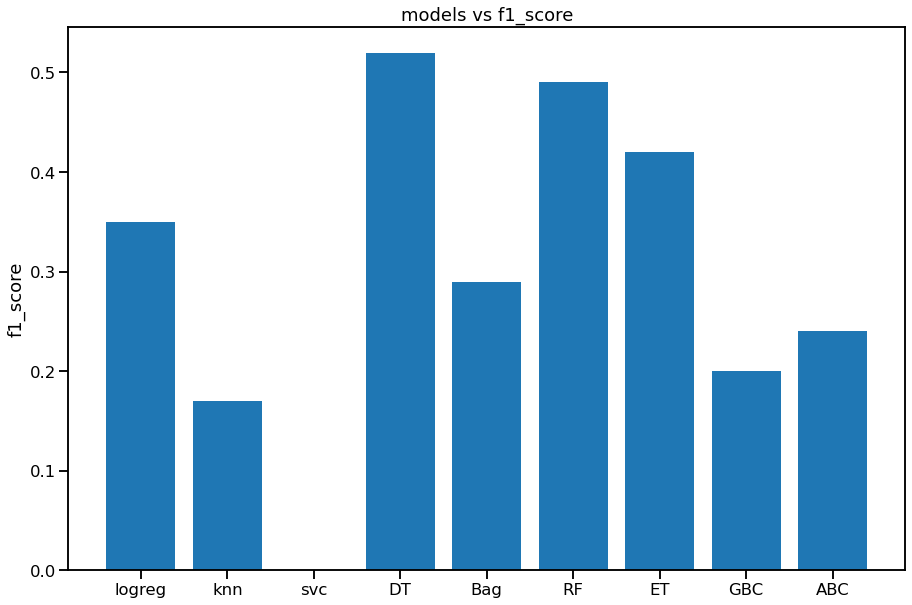

In [56]:
# visualize the f1 score of models
import matplotlib.pyplot as plt

models = ["logreg", "knn", "svc", "DT", "Bag", "RF", "ET", "GBC", "ABC"]
f1_scores = [0.35, 0.17, 0.0, 0.52, 0.29, 0.49, 0.42, 0.2, 0.24]


fig, ax = plt.subplots(figsize=(15, 10))


ax.bar(models, f1_scores)

ax.set_ylabel("f1_score")
ax.set_title("models vs f1_score")
# ax.legend(title='Fruit color')
plt.tight_layout
plt.show()

## Improve Performance of Model

To improve performance, 

In [ ]:
# DecisionTreee

dt = DecisionTreeClassifier(max_depth=7, max_features=3, random_state=42) 

dt = dt.fit(X_train, y_train)

# Make predictions on the test data
y_pred = dt.predict(X_test_s)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)


print(
    "Best score (precision): \n",
    dt.best_score_,
    "\n \n",
    "Best hyperparameters: \n",
    dt.best_params_,
    "\n \n",
    "Best coefficients: \n",
    dt.best_estimator_,
    "\n",
)